# Predicting Forests - Mod 5 - Kaggle Competition - Machine Learning

By Valentina Fontiveros

### Import Libraries

In [1]:
import pandas as pd

### Exploratory Data Analysis

In [2]:
# read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# descriptive statistics
train.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [4]:
# training samples: 15120

In [5]:
test.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,...,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000
mean,298066.500000,2964.977407,155.629558,14.039635,270.556622,46.294408,2367.143116,212.131133,223.435026,142.726951,...,0.044768,0.091588,0.078704,0.002808,0.003161,0.000193,0.000467,0.026233,0.023236,0.014651
std,163359.093604,273.157030,111.962120,7.450155,212.500153,58.209469,1561.482002,26.661063,19.668053,38.030094,...,0.206795,0.288444,0.269277,0.052916,0.056137,0.013877,0.021594,0.159827,0.150652,0.120152
min,15121.000000,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,156593.750000,2818.000000,58.000000,9.000000,108.000000,7.000000,1116.000000,198.000000,213.000000,119.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,298066.500000,2999.000000,127.000000,13.000000,228.000000,29.000000,2018.000000,218.000000,226.000000,143.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,439539.250000,3164.000000,260.000000,18.000000,390.000000,69.000000,3349.000000,231.000000,237.000000,168.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,581012.000000,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# test samples 565892

In [7]:
train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

In [9]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


### Data QC

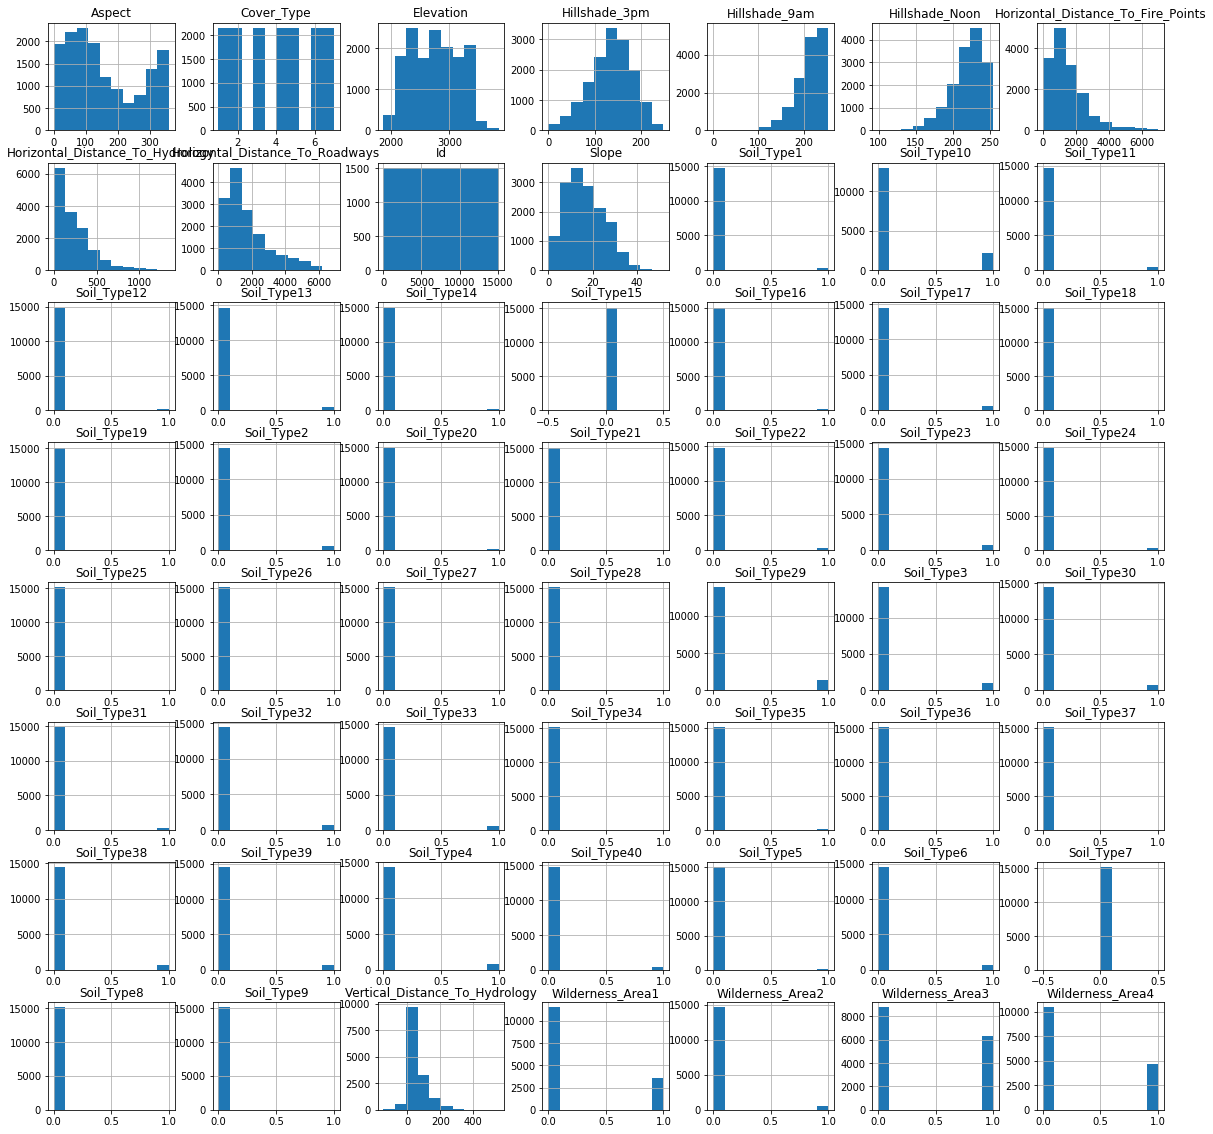

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
train.hist(figsize=(20,20))
plt.show()

### Preprocessing Steps - Scaling

In [11]:
# Normalize
train.set_index('Id',inplace=True)  # Set Record Id As Index
features = train.columns[0:-1]      # create a list of features than don't include target/label


X = train[features] # dataframe of features
y_train = train.Cover_Type # Series of Labels


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()   

scaler.fit(X)   # Scale data

X_train = pd.DataFrame(scaler.transform(X))
X_train.columns = X.columns

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [12]:
len(features)

54

In [13]:
# preview training dataset
X_train.head(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,-0.367095,-0.959980,-1.597132,0.146639,-0.834074,-0.908681,0.271454,0.571653,0.281259,4.334805,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
1,-0.381461,-0.914559,-1.715424,-0.072337,-0.932054,-0.999246,0.238732,0.703225,0.346627,4.285710,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
2,0.130912,-0.160577,-0.887379,0.194243,0.227369,1.106379,0.696843,0.834797,-0.002005,4.191156,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
3,0.085421,-0.015231,0.177250,0.070474,1.092853,1.038455,0.827731,0.834797,-0.285268,4.272981,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
4,-0.369489,-1.014485,-1.715424,-0.353198,-0.850404,-0.998491,0.238732,0.659368,0.324838,4.237524,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
5,-0.407798,-0.224166,-1.242255,0.346574,-1.079023,-1.243015,0.565954,0.790940,0.106943,4.109330,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
6,-0.343152,-1.014485,-1.123963,0.203764,-0.752425,-0.815853,0.304176,0.264652,0.063364,4.313894,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
7,-0.345547,-0.978148,-1.478839,0.032391,-0.719765,-0.861135,0.304176,0.483939,0.194101,4.288437,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
8,-0.316816,-1.014485,-0.887379,0.060953,0.080400,-0.790947,0.336898,0.089223,-0.045584,4.302984,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939
9,-0.328787,-0.887307,-0.769087,0.094276,-0.654445,-0.813589,0.500509,0.001508,-0.241689,4.290256,...,-0.149835,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939


In [14]:
import xgboost as xgb


In [15]:
from sklearn.metrics import accuracy_score
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train,y_train_pred)

In [16]:
train_accuracy

0.7742063492063492

### Tuning Classifier

In [17]:
list(range(100,500,50))

[100, 150, 200, 250, 300, 350, 400, 450]

In [18]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [3],
    'min_child_weight': [10],
    'subsample': [1],
    'n_estimators': range(100,500,100)
}

In [19]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
#val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, y_train_pred)
#val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
#print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

### Submission Formatting

In [20]:
test.set_index('Id',inplace=True) 
scaler2 = scaler.fit(test)
X_test = pd.DataFrame(scaler2.transform(test))
X_test.columns = test.columns
y_test_pred = clf.predict(X_test)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
data = [test.index, y_test_pred]
submission_df = pd.DataFrame(data={'Id':test.index,'Cover_Type':y_test_pred})
submission_df.head()

,Id,Cover_Type
0,15121,5
1,15122,5
2,15123,5
3,15124,5
4,15125,5


In [ ]:
submission_df.Cover_Type.unique()

In [23]:
submission_df.to_csv('first_pass.csv',index=False)

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
# Format of submission ()
submission.head()